# Create .avi from Neuralynx .nvt files 
- Creates a video file of LED positions from Neuralynx bitfield data


In [1]:
import numpy as np
import scipy as sp
from matplotlib import path
import matplotlib.pyplot as plt
import cv2
from cv2 import VideoWriter, VideoWriter_fourcc
import glob
# from https://github.com/vandermeerlab/nept/loaders_neuralynx.py 
def load_nvt(filename, remove_empty=False):
    """Loads a neuralynx .nvt file.
    Parameters
    ----------
    filename: str
    remove_empty: bool
    Returns
    -------
    nvt_data: dict
        With time, x, and y as keys.
    """
    with open(filename, "rb") as f:

        # Neuralynx files have a 16kbyte header
        header = f.read(16 * 2 ** 10)

        # The format for .nvt files according the the neuralynx docs is
        # uint16 - beginning of the record
        # uint16 - ID for the system
        # uint16 - size of videorec in bytes
        # uint64 - timestamp in microseconds
        # uint32 x 400 - points with the color bitfield values
        # int16 - unused
        # int32 - extracted X location of target
        # int32 - extracted Y location of target
        # int32 - calculated head angle in degrees clockwise from the positive Y axis
        # int32 x 50 - colored targets using the same bitfield format used to extract colors earlier
        dt = np.dtype(
            [
                ("filler1", "<h", 3),
                ("time", "<Q"),
                ("points", "<i", 400),
                ("filler2", "<h"),
                ("x", "<i"),
                ("y", "<i"),
                ("head_angle", "<i"),
                ("targets", "<i", 50),
            ]
        )
        data = np.fromfile(f, dt)

    nvt_data = dict()
    nvt_data["time"] = data["time"] * 1e-6
    nvt_data["x"] = np.array(data["x"], dtype=float)
    nvt_data["y"] = np.array(data["y"], dtype=float)
    nvt_data["points"] = np.array(data["points"], dtype=float)

    empty_idx = (data["x"] == 0) & (data["y"] == 0)
    for key in nvt_data:
        if remove_empty:
            nvt_data[key] = nvt_data[key][~empty_idx]

    return nvt_data

def read_point_data(nvt_data):
    # Initialize output variables
    red_all = []
    green_all = []
    x_all = []
    y_all = []

    # loop through points convert from decimal to binary and back to integer
    numbers = nvt_data['points'].astype('int')
    for cell in range(numbers.shape[0]):
        red = []
        green = []
        x = []
        y = []
        for sample in range(numbers.shape[1]):
            bin_number = "{0:b}".format(numbers[cell,sample]).zfill(32)
            red.append(int(bin_number[1],2))
            green.append(int(bin_number[2],2))
            x.append(int(bin_number[20:32],2))
            y.append(int(bin_number[4:16],2))
                  
        red_all.append(red)
        green_all.append(green)
        x_all.append(x)
        y_all.append(y)

    x_all = np.array(x_all)
    y_all = np.array(y_all)
    red_all = np.array(red_all)
    green_all = np.array(green_all)
    
    return x_all,y_all,red_all,green_all

# Create fill_points function
def fill_points(points):
    new_points_x = []
    new_points_y = []
    # Fill x- points 
    for point in np.unique(points[:,1]):
        temp_range = np.arange(np.min(points[points[:,1] == point][:,0])+1,np.max(points[points[:,1] == point][:,0]))
        if temp_range.size == 0:
            continue
        new_points_x.append(temp_range)
        new_points_y.append(np.tile(point,len(temp_range)))
    
    if (len(new_points_x) == 0) | (len(new_points_y) == 0):
        return points
    
    new_points = np.column_stack([np.hstack(new_points_x),np.hstack(new_points_y)])
    new_points[new_points[:,0] > 720] = 0
    new_points[new_points[:,1] > 480] = 0
    return new_points

def create_frame_from_bitfield(x_all,y_all,red_all,green_all):
    # Find points that correspond to red leds
    red_points = np.column_stack([x_all[red_all>0],y_all[red_all>0]])
    red_points = fill_points(red_points)
    # Find points that correspond to green leds
    green_points = np.column_stack([x_all[green_all>0],y_all[green_all>0]])
    # fill them
    green_points = fill_points(green_points)
    # initialize frame
    rgbArray = np.zeros((480,720,3), 'uint8')
    # Add color to location of LED points
    rgbArray[red_points[:,1],red_points[:,0], 0] = 255
    rgbArray[green_points[:,1],green_points[:,0], 1] = 255
    rgbArray[green_points[:,1],green_points[:,0], 2] = 0

    return rgbArray


def remove_bad_x_inds_all(x_all):
    # removes indicies outside of frame and defaults to 0
    x_all_idx = (np.hstack(x_all) > 720)
    x_all_temp = np.hstack(x_all)
    x_all_temp[x_all_idx] = 0
    x_all_temp = np.reshape(x_all_temp,(len(x_all),400))
    return x_all_temp

def remove_bad_y_inds_all(y_all):
    # removes indicies outside of frame and defaults to 0
    y_all_idx = (np.hstack(y_all) > 480)
    y_all_temp = np.hstack(y_all)
    y_all_temp[y_all_idx] = 0
    y_all_temp = np.reshape(y_all_temp,(len(y_all),400))
    return y_all_temp

def write_avi(x_all,y_all,red_all,green_all,save_path):
    # Initialize video variables 
    width = 720
    height = 480
    FPS = 30
    ts = x_all.shape[0]

    # Intialize video codec
    fourcc = VideoWriter_fourcc(*'DIVX')
    video = VideoWriter(save_path+'VT1.avi', fourcc, float(FPS), (height,width))

    # write frames
    for i in np.arange(ts):
        frame = create_frame_from_bitfield(x_all[i],y_all[i],red_all[i],green_all[i])
        video.write(np.flip(frame, axis=2))
    video.release()
    cv2.destroyAllWindows()
    print('video saved to: '+save_path)
    
def main(data_path):
    # find neuralynx video file
    file = glob.glob(data_path+'*.nvt')
    nvt_data = load_nvt(file[0])
    
    # pull position and led color info from bitfields
    x_all,y_all,red_all,green_all = read_point_data(nvt_data)
    
    # convert indicides out of range to zero (Neuralynx default for missed tracking)
    x_all = remove_bad_x_inds(x_all)
    y_all = remove_bad_x_inds(y_all)
    
    # Write video
    write_avi(x_all,y_all,red_all,green_all,data_path)

## Identify .nvt files in folder and read in data

In [ ]:
import glob 

data_path = 'F:\\ClarkP30_Recordings\\Data\\LB03\\2017-03-10_17-24-37\\'

file = glob.glob(data_path+'*.nvt')
nvt_data = load_nvt(file[0])

## Pull out the points and led color data and convert to xy coordinates and binary, respective

In [ ]:
x_all,y_all,red_all,green_all = read_point_data(nvt_data)

x_all = remove_bad_x_inds(x_all)
y_all = remove_bad_x_inds(y_all)

## Plot example frame with colorcoded points

In [ ]:
i=2246
rgbArray = np.zeros((480,720,3), 'uint8')
rgbArray[x_all[i][red_all[i]>0],y_all[i][red_all[i]>0], 0] = 255
rgbArray[x_all[i][green_all[i]>0],y_all[i,][green_all[i]>0], 1] = 255
plt.figure(figsize=(10,10))
plt.imshow(rgbArray)

### Note that the boundary of the LEDs are plotted. This might making tracking a bit more difficult for DeepLabCut. Lets fill in the area to improve ease of tracking.

## We'll create coordinates in between LED max/min values. 
* Next we'll loop through the points using fill_points
* Use the new points to plot the leds


In [ ]:
i=0
# Find points that correspond to red leds
red_points = np.column_stack([x_all[i][red_all[i]>0],y_all[i][red_all[i]>0]])
# fill them
red_points = fill_points(red_points)
# Find points that correspond to green leds
green_points = np.column_stack([x_all[i][green_all[i]>0],y_all[i][green_all[i]>0]])
# fill them
green_points = fill_points(green_points)

### Plot the results of filling the gaps between the boundary

In [ ]:
i=1
rgbArray = np.zeros((480,720,3), 'uint8')
rgbArray[red_points[:,0],red_points[:,1], 0] = 255
rgbArray[green_points[:,0],green_points[:,1], 1] = 255
plt.figure(figsize=(10,10))
plt.imshow(rgbArray)

## Lets use cv2 to write and save each video frame

### In this section we will: 
* Import cv2,matplotlib
* Initialize video codec
* Create frames 
* Write frames to VideoWriter object 
* Save video

### Loop through each time and create video 

In [2]:
data_path = 'F:\\ClarkP30_Recordings\\Data\\LB03\\2017-03-10_17-24-37\\'

# find neuralynx video file
file = glob.glob(data_path+'*.nvt')
nvt_data = load_nvt(file[0])

# pull position and led color info from bitfields
x_all,y_all,red_all,green_all = read_point_data(nvt_data)

# convert indicides out of range to zero (Neuralynx default for missed tracking)
x_all = remove_bad_x_inds_all(x_all)
y_all = remove_bad_y_inds_all(y_all)

    

    

NameError: name 'remove_bad_x_inds' is not defined

In [8]:
# pull position and led color info from bitfields
x_all,y_all,red_all,green_all = read_point_data(nvt_data)

In [13]:
np.hstack(x_all)
np.min(np.hstack(x_all))
# plt.figure(figsize=(10,10))
# plt.hist(np.hstack(x_all),100)

0

In [97]:

# Initialize video variables 
height = 480
width = 720
FPS = 30
ts = x_all.shape[0]

# Intialize video codec
fourcc = VideoWriter_fourcc(*'MP42')
video = VideoWriter('D:/Users/BClarkLab/github/position_tracking/VT1_test5.avi', fourcc, float(FPS), (width, height))

# write frames
for i in range(1000):
    frame = create_frame_from_bitfield(x_all[i],y_all[i],red_all[i],green_all[i])
    video.write(frame) #np.flip(frame, axis=2)
    
video.release()

print('video saved to: '+ data_path)
    

# video.release()

video saved to: F:\ClarkP30_Recordings\Data\LB03\2017-03-10_17-24-37\


In [ ]:
for i in range(ts):
    my_frame = create_frame_from_bitfield(x_all[i],y_all[i],red_all[i],green_all[i])
    print(np.min(my_frame))

(480, 780, 3)


0

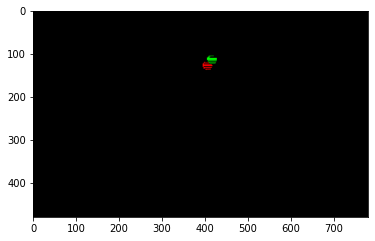

In [95]:
i=2000

my_frame = create_frame_from_bitfield(x_all[i],y_all[i],red_all[i],green_all[i])
plt.figure()

plt.imshow(my_frame)
print(my_frame.shape)
my_frame.dtype

# plt.figure()
# plt.imshow(my_frame[:,:,2])
# plt.colorbar()

np.min(my_frame[:,:,2])

(480, 720, 3)


255

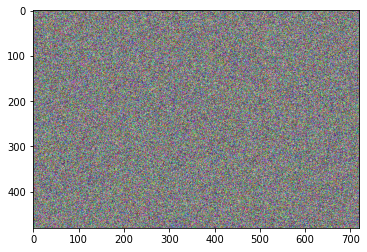

In [96]:
plt.imshow(frame)
print(frame.shape)
frame.dtype
np.max(frame)

In [93]:
import numpy as np
from cv2 import VideoWriter, VideoWriter_fourcc

# width = 1280
# height = 720
# FPS = 24

height = 480
width = 720
FPS = 30
seconds = 10

fourcc = VideoWriter_fourcc(*'MP42')
video = VideoWriter('./noise_2.avi', fourcc, float(FPS), (width, height))

for _ in range(FPS*seconds):
    frame = np.random.randint(0, 256, 
                              (height, width, 3), 
                              dtype=np.uint8)
    video.write(frame)
video.release()

In [11]:
def write_avi_from_bitfield(nvt_data,data_path):
    numbers = nvt_data['points'].astype('int')
    width = 720
    height = 480
    FPS = 30
    ts = numbers.shape[0]
    # Intialize video codec
    fourcc = VideoWriter_fourcc(*'DIVX')
    video = VideoWriter('./VT1.avi', fourcc, float(FPS), (height,width))
    # loop through points convert from decimal to binary and back to integer
    
    for cell in range(numbers.shape[0]):
        red = []
        green = []
        x = []
        y = []
        for sample in range(numbers.shape[1]):
            bin_number = "{0:b}".format(numbers[cell,sample]).zfill(32)
            red.append(int(bin_number[1],2))
            green.append(int(bin_number[2],2))
            x.append(int(bin_number[20:32],2))
            y.append(int(bin_number[4:16],2))
            
        # convert list to array 
        x = np.array(x)
        y = np.array(y)
        red = np.array(red)
        green = np.array(green)
        
        #remove out bound indicies
        x = remove_bad_x_inds(x)
        y = remove_bad_y_inds(y)
        
        # Create frame 
        frame = create_frame_from_bitfield(x,y,red,green)
        video.write(np.flip(frame, axis=2))

    video.release()
    print('video saved to: '+data_path)
    

def remove_bad_x_inds(x_all):
    # removes indicies outside of frame and defaults to 0
    x_all_idx = (x_all > 720)
    x_all[x_all_idx] = 0
    return x_all

def remove_bad_y_inds(y_all):
    # removes indicies outside of frame and defaults to 0
    y_all_idx = (y_all > 480)
    y_all[y_all_idx] = 0
    return y_all

def create_frame_from_bitfield(x_all,y_all,red_all,green_all):
    # Find points that correspond to red leds
    red_points = np.column_stack([x_all[red_all>0],y_all[red_all>0]])
    red_points = fill_points(red_points)
    # Find points that correspond to green leds
    green_points = np.column_stack([x_all[green_all>0],y_all[green_all>0]])
    # fill them
    green_points = fill_points(green_points)
    # initialize frame
    rgbArray = np.zeros((480,720,3), 'uint8')
    # Add color to location of LED points
    rgbArray[red_points[:,1],red_points[:,0], 0] = 255
    rgbArray[green_points[:,1],green_points[:,0], 1] = 255
    return rgbArray

# Create fill_points function
def fill_points(points):
    new_points_x = []
    new_points_y = []
    # Fill x- points 
    for point in np.unique(points[:,1]):
        temp_range = np.arange(np.min(points[points[:,1] == point][:,0])+1,np.max(points[points[:,1] == point][:,0]))
        if temp_range.size == 0:
            continue
        new_points_x.append(temp_range)
        new_points_y.append(np.tile(point,len(temp_range)))
    
    if (len(new_points_x) == 0) | (len(new_points_y) == 0):
        return points
    
    new_points = np.column_stack([np.hstack(new_points_x),np.hstack(new_points_y)])
    new_points[new_points[:,0] > 720] = 0
    new_points[new_points[:,1] > 480] = 0
    return new_points

# from https://github.com/vandermeerlab/nept/loaders_neuralynx.py 
def load_nvt(filename, remove_empty=False):
    """Loads a neuralynx .nvt file.
    Parameters
    ----------
    filename: str
    remove_empty: bool
    Returns
    -------
    nvt_data: dict
        With time, x, and y as keys.
    """
    with open(filename, "rb") as f:

        # Neuralynx files have a 16kbyte header
        header = f.read(16 * 2 ** 10)

        # The format for .nvt files according the the neuralynx docs is
        # uint16 - beginning of the record
        # uint16 - ID for the system
        # uint16 - size of videorec in bytes
        # uint64 - timestamp in microseconds
        # uint32 x 400 - points with the color bitfield values
        # int16 - unused
        # int32 - extracted X location of target
        # int32 - extracted Y location of target
        # int32 - calculated head angle in degrees clockwise from the positive Y axis
        # int32 x 50 - colored targets using the same bitfield format used to extract colors earlier
        dt = np.dtype(
            [
                ("filler1", "<h", 3),
                ("time", "<Q"),
                ("points", "<i", 400),
                ("filler2", "<h"),
                ("x", "<i"),
                ("y", "<i"),
                ("head_angle", "<i"),
                ("targets", "<i", 50),
            ]
        )
        data = np.fromfile(f, dt)

    nvt_data = dict()
    nvt_data["time"] = data["time"] * 1e-6
    nvt_data["x"] = np.array(data["x"], dtype=float)
    nvt_data["y"] = np.array(data["y"], dtype=float)
    nvt_data["points"] = np.array(data["points"], dtype=float)

    empty_idx = (data["x"] == 0) & (data["y"] == 0)
    for key in nvt_data:
        if remove_empty:
            nvt_data[key] = nvt_data[key][~empty_idx]

    return nvt_data

In [12]:
import glob
import numpy as np
import cv2
from cv2 import VideoWriter, VideoWriter_fourcc
data_path = 'F:\\ClarkP30_Recordings\\Data\\LB03\\2017-03-10_17-24-37\\'

file = glob.glob(data_path+'*.nvt')
nvt_data = load_nvt(file[0])
write_avi_from_bitfield(nvt_data,data_path)

video saved to: F:\ClarkP30_Recordings\Data\LB03\2017-03-10_17-24-37\
